In [1]:
import torchvision

from torch import cuda, device
from src.plots import plot_vae_training_result, plot_cifar_image
from src.vae.cifar_vae import VaeAutoencoder
from src.image_classifier.image_classifier import CIFAR10Classifier

device = device('cuda' if cuda.is_available() else 'cpu')

In [2]:
# convert data to a normalized torch.FloatTensor
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

training_data = torchvision.datasets.CIFAR10(root='../data/CIFAR10_train', train=True, download=True, transform=transform)
testing_data = torchvision.datasets.CIFAR10(root='../data/CIFAR10_test', train=False, download=True, transform=transform)

print(training_data)
print(testing_data)

input = training_data.data[:50000]
labels = training_data.targets[:50000]

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../data/CIFAR10_train
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../data/CIFAR10_test
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


In [ ]:
# Train VAE
vae = VaeAutoencoder(dim_encoding=100).to(device)

vae_model, vae_loss_li, kl_loss_li, recons_loss_li = vae.train_model(
    training_data=training_data,
    batch_size=32,
    beta=0.000075,
    epochs=50,
    learning_rate=0.001
)

Finished epoch:  1
Finished epoch:  2


In [ ]:
# plot results
plot_vae_training_result(
    input=input,
    labels=labels,
    vae_model=vae_model,
    vae_loss_li=vae_loss_li,
    kl_loss_li=kl_loss_li,
    recons_loss_li=recons_loss_li
)

(5, 32, 32, 3)
(5, 32, 32, 3)


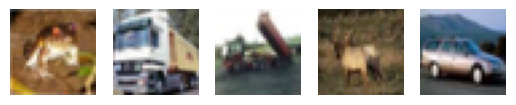

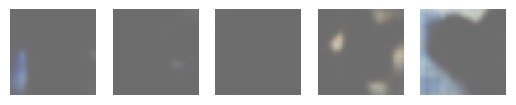

In [5]:
# check output
samples = training_data.data[:5]
plot_cifar_image(samples)

# vae expects permuted input of (<bath_size, channels, height, width>)
output = vae.generate_data(5)
output = output.permute(0, 3, 2, 1).cpu().detach().numpy()

assert output.shape == (5, 32, 32, 3)

plot_cifar_image(output)

In [8]:
# train classifier for performance evaluation
classifier = CIFAR10Classifier()
if cuda.is_available():
    classifier.cuda()

classifier.train_model(training_data, batch_size=32, learning_rate=0.01, epochs=2)
accuracy = classifier.test_model(testing_data)
print("Test accuracy: ", accuracy)

Epoch done:  1


KeyboardInterrupt: 

In [11]:
x = vae.generate_data(n_samples=10000)
print("Number of images: ", x.shape[0])

labels = classifier.generate_labels(x)
print("Labels: ", labels.shape)

In [10]:
# # Determine FID
# # generate 500 images
# syn_input, _ = vae.generate_data(n_samples=500)
# input = input[:500]
# 
# input_rgb = input.view(-1, 1, 28, 28).repeat(1, 3, 1, 1)
# syn_input_rgb = syn_input.view(-1, 1, 28, 28).repeat(1, 3, 1, 1)
# 
# # compute FID score
# fid_score = frechet_inception_distance(input_rgb, syn_input_rgb)
# print("Frechet Inception Distance: ", fid_score)